# Import Dependencies

In [ ]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import random
import time
import torchtext

import itertools

# Reproducibility






In [ ]:
def fix_random(seed):

  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [ ]:
fix_random(seed=1234)

# Runtime Settings

Here we set the `device`, which is used to place tensors on our GPU, if we have one.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

If no GPU is available, you should change the Runtime settings. 

In [ ]:
!nvidia-smi

Tue Dec  1 15:58:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     8W /  75W |     10MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get the Data

In [ ]:
import urllib.request  #  download files
import zipfile  #  unzip files

# We start by downloading the dataset and extract it to a folder

dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("Dataset")

print("Successful extraction")

Successful download
Successful extraction


In [ ]:
# we have modified the class SequenceTaggingDataset from the pytorch module torchtext in order to
# encode the dataset in a more comfortable way to use

class SequenceTaggingDataset(data.Dataset):
  @staticmethod
  def sort_key(example):
    for attr in dir(example):
      if not callable(getattr(example, attr)) and \
              not attr.startswith("__"):
        return len(getattr(example, attr))
    return 0

  def __init__(self, path, fields, split, encoding="utf-8", separator="\t", **kwargs):
    examples = []
    columns = []

    # split the dataset in training, validation and test set as required
    if split == "train":
      file_range = range(1,101)
    elif split == "val":
      file_range =  range(101,151)
    else:
      file_range = range(151,200)

    # for each document we extract the text and the corresponding tags
    for filename in os.listdir(path):
      if int(filename[4:8]) in file_range:
        file_path = os.path.join(path, filename)

        with open(file_path, encoding=encoding) as input_file:
            for line in input_file:
              line = line.strip()

              # don't consider the empty lines
              if line != "": 
                
                for i, column in enumerate(line.split(separator)):
                  if len(columns) < i+1 :
                    columns.append([])
                  columns[i].append(column)                
          
            if columns:
              examples.append(data.Example.fromlist(columns, fields))
              columns = []
        super(SequenceTaggingDataset, self).__init__(examples, fields, **kwargs)

One of the key parts of TorchText is the `Field`. The `Field` handles how your dataset is processed.

The `TEXT` fields handle how the text is dealt with. By setting `lower = True` we lowercase all the text.

In the `TB_TAGS` field we remove the initialization of a default unknown token by setting `unk_token = None`


In [ ]:
TRAIN_TEXT = data.Field(lower = True)
VAL_TEXT = data.Field(lower = True)
TEST_TEXT = data.Field(lower = True)

TB_TAGS = data.Field(unk_token = None)

# We then define fields, which handles passing our fields to the dataset
train_fields = (("words", TRAIN_TEXT), ("tags", TB_TAGS))
val_fields = (("words", VAL_TEXT), ("tags", TB_TAGS))
test_fields = (("words", TEST_TEXT), ("tags", TB_TAGS))

dataset_path = "Dataset/dependency_treebank"

#split dataset in train, validation and test
train_data = SequenceTaggingDataset(dataset_path, train_fields, split = "train")
val_data = SequenceTaggingDataset(dataset_path, val_fields, split = "val")
test_data = SequenceTaggingDataset(dataset_path, test_fields, split = "test")


## Visualize the Data

In [ ]:
print("Number of training examples: {}".format(len(train_data)))
print("Number of validation examples: {}".format(len(val_data)))
print("Number of testing examples: {}".format(len(test_data)))

Number of training examples: 100
Number of validation examples: 50
Number of testing examples: 49


In [ ]:
print(vars(train_data.examples[0]))

{'words': ['cooper', 'tire', '&', 'rubber', 'co.', 'said', 'it', 'has', 'reached', 'an', 'agreement', 'in', 'principle', 'to', 'buy', 'buildings', 'and', 'related', 'property', 'in', 'albany', ',', 'ga.', ',', 'from', 'bridgestone\\/firestone', 'inc', '.', 'terms', 'were', "n't", 'disclosed', '.', 'the', 'tire', 'maker', 'said', 'the', 'buildings', 'consist', 'of', '1.8', 'million', 'square', 'feet', 'of', 'office', ',', 'manufacturing', 'and', 'warehousing', 'space', 'on', '353', 'acres', 'of', 'land', '.'], 'tags': ['NNP', 'NNP', 'SYM', 'NNP', 'NNP', 'VBD', 'PRP', 'VBZ', 'VBN', 'DT', 'NN', 'IN', 'NN', 'TO', 'VB', 'NNS', 'CC', 'JJ', 'NN', 'IN', 'NNP', ',', 'NNP', ',', 'IN', 'NNP', 'NNP', '.', 'NNS', 'VBD', 'RB', 'VBN', '.', 'DT', 'NN', 'NN', 'VBD', 'DT', 'NNS', 'VBP', 'IN', 'CD', 'CD', 'JJ', 'NNS', 'IN', 'NN', ',', 'NN', 'CC', 'NN', 'NN', 'IN', 'CD', 'NNS', 'IN', 'NN', '.']}


In [ ]:
print(vars(train_data.examples[0])["words"])

['cooper', 'tire', '&', 'rubber', 'co.', 'said', 'it', 'has', 'reached', 'an', 'agreement', 'in', 'principle', 'to', 'buy', 'buildings', 'and', 'related', 'property', 'in', 'albany', ',', 'ga.', ',', 'from', 'bridgestone\\/firestone', 'inc', '.', 'terms', 'were', "n't", 'disclosed', '.', 'the', 'tire', 'maker', 'said', 'the', 'buildings', 'consist', 'of', '1.8', 'million', 'square', 'feet', 'of', 'office', ',', 'manufacturing', 'and', 'warehousing', 'space', 'on', '353', 'acres', 'of', 'land', '.']


In [ ]:
print(vars(train_data.examples[0])["tags"])

['NNP', 'NNP', 'SYM', 'NNP', 'NNP', 'VBD', 'PRP', 'VBZ', 'VBN', 'DT', 'NN', 'IN', 'NN', 'TO', 'VB', 'NNS', 'CC', 'JJ', 'NN', 'IN', 'NNP', ',', 'NNP', ',', 'IN', 'NNP', 'NNP', '.', 'NNS', 'VBD', 'RB', 'VBN', '.', 'DT', 'NN', 'NN', 'VBD', 'DT', 'NNS', 'VBP', 'IN', 'CD', 'CD', 'JJ', 'NNS', 'IN', 'NN', ',', 'NN', 'CC', 'NN', 'NN', 'IN', 'CD', 'NNS', 'IN', 'NN', '.']


## Build vocabularies

We build the vocabularies by loading the `GloVe` pre-trained token embeddings.

In [ ]:
# unk_init is used to initialize the token embeddings which are not in the pre-trained embedding vocabulary
TRAIN_TEXT.build_vocab(train_data, 
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

VAL_TEXT.build_vocab(val_data,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

TEST_TEXT.build_vocab(test_data,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


TB_TAGS.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:32, 2.20MB/s]                          
100%|█████████▉| 399075/400000 [00:15<00:00, 24574.84it/s]

In [ ]:
print("Unique tokens in the TRAIN_TEXT vocabulary: {}".format(len(TRAIN_TEXT.vocab)))
print("Unique tokens in TB_TAG vocabulary: {}".format(len(TB_TAGS.vocab)))

Unique tokens in the TRAIN_TEXT vocabulary: 7406
Unique tokens in TB_TAG vocabulary: 46


In [ ]:
print(TRAIN_TEXT.vocab.freqs.most_common(20))

[(',', 2570), ('the', 2329), ('.', 1936), ('of', 1177), ('to', 1031), ('a', 1026), ('in', 949), ('and', 815), ('for', 459), ("'s", 431), ('that', 425), ('``', 404), ("''", 394), ('$', 338), ('is', 324), ('said', 311), ('it', 304), ('on', 259), ('mr.', 245), ('at', 224)]


In [ ]:
def tag_percentage(tag_counts):
  total_count = sum([count for tag, count in tag_counts])
  tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts] 
  return tag_counts_percentages

In [ ]:
print("Tag\t\tCount\t\tPercentage\n")
for tag, count, percent in tag_percentage(TB_TAGS.vocab.freqs.most_common()):
  print("{}\t\t{}\t\t{:4.1f}%".format(tag,count,percent*100))

Tag		Count		Percentage

NN		6270		13.2%
NNP		5202		11.0%
IN		4952		10.5%
DT		4076		 8.6%
NNS		3004		 6.3%
JJ		2992		 6.3%
,		2571		 5.4%
.		1959		 4.1%
VBD		1548		 3.3%
RB		1490		 3.1%
CD		1439		 3.0%
VB		1195		 2.5%
CC		1141		 2.4%
VBZ		1133		 2.4%
VBN		1031		 2.2%
TO		1028		 2.2%
PRP		954		 2.0%
VBG		763		 1.6%
VBP		727		 1.5%
MD		413		 0.9%
``		409		 0.9%
PRP$		409		 0.9%
POS		403		 0.9%
''		399		 0.8%
$		342		 0.7%
:		293		 0.6%
WDT		204		 0.4%
JJR		157		 0.3%
WP		141		 0.3%
RP		140		 0.3%
NNPS		95		 0.2%
JJS		93		 0.2%
WRB		92		 0.2%
RBR		86		 0.2%
-RRB-		55		 0.1%
-LRB-		52		 0.1%
EX		49		 0.1%
RBS		19		 0.0%
LS		10		 0.0%
PDT		9		 0.0%
WP$		6		 0.0%
FW		2		 0.0%
SYM		1		 0.0%
UH		1		 0.0%
#		1		 0.0%


## Create the `Iterators`

The final part of data preparation is handling the iterator.
We also set the batch size.

In [ ]:
BATCH_SIZE = 4

train_iterator, val_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = BATCH_SIZE,
    device = device)


# Baseline Model

In [ ]:
# set models' parameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = len(TB_TAGS.vocab)
N_EPOCHS = 50

# get the pad index from the text and tags vocabularies
PAD_IDX = TRAIN_TEXT.vocab.stoi[TRAIN_TEXT.pad_token]
TAG_PAD_IDX = TB_TAGS.vocab.stoi[TB_TAGS.pad_token]

# It's common to initialize the embedding of the pad token to all zeros. 
TRAIN_TEXT.vocab.vectors[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
VAL_TEXT.vocab.vectors[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
TEST_TEXT.vocab.vectors[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# we place the embeddings on our GPU, if we have one
TRAIN_TEXT.vocab.vectors = TRAIN_TEXT.vocab.vectors.to(device)
VAL_TEXT.vocab.vectors = VAL_TEXT.vocab.vectors.to(device)
TEST_TEXT.vocab.vectors = TEST_TEXT.vocab.vectors.to(device)

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim):
    
    super().__init__()
    
    # bidirectional lstm layer
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
    
    # dense layer
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    # dropout
    self.dropout = nn.Dropout(0.25)

    
  def forward(self, embedded):
    
    # pass embeddings into LSTM
    outputs, (hidden, cell) = self.lstm(self.dropout(embedded))
    
    # get the predictions of the tags
    predictions = self.fc(outputs)
    
    return predictions

In [ ]:
# initialize the model
bilstm = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

We initialize the weights from a Normal Distribution

In [ ]:
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.normal_(param.data, mean = 0, std = 0.1)
        
bilstm.apply(init_weights)

BiLSTM(
  (lstm): LSTM(100, 64, bidirectional=True)
  (fc): Linear(in_features=128, out_features=46, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
import locale
locale.setlocale(locale.LC_ALL, '')

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The model has {:n} trainable parameters".format(count_parameters(bilstm)))

The model has 90,926 trainable parameters


In [ ]:
# define the optimizer
optimizer = optim.Adam(bilstm.parameters(), lr=0.01)

# by setting ignore_index = TAG_PAD_IDX we don't calculate the loss when the target is a <pad> token
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [ ]:
# we place our model and loss function on our GPU, if we have one
bilstm = bilstm.to(device)
criterion = criterion.to(device)

## Train the Network

### Visual Debug with Tensorboard


In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

###Train

To have a better idea of the performance of the model, we compute the accuracy by not considering the pad token 

In [ ]:
def categorical_accuracy(preds, y, tag_pad_idx, crf = False):
  
  # don't consider the pad token
  non_pad_elements = torch.nonzero(y != tag_pad_idx) 
  
  # with crf we don't need to get the index of max probability, since the crf model returns it directly
  if crf:
    correct = preds[non_pad_elements].eq(y[non_pad_elements]) 
  else:
    # get the index of the max probability
    max_preds = preds.argmax(dim = 1, keepdim = True) 
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]) 

  if torch.cuda.is_available():
    return correct.sum() / torch.cuda.FloatTensor([y[non_pad_elements].shape[0]])
  else:
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

In [ ]:
# we have defined this function to get the embedding from every batch of text
def get_text_embedding(batch, text_field):
  result =  torch.stack([torch.stack([text_field.vocab.vectors[word] for word in sequence]) for sequence in batch])
  return result

In [ ]:
def train(writer, model, iterator, optimizer, criterion, tag_pad_idx, log_interval, epoch, text_field):
  
  epoch_loss = 0
  epoch_acc = 0

  samples_train = 0
  num_batches = len(iterator)
  
 
  model.train()
  
  for idx_batch, batch in enumerate(iterator):
    
    embedded = get_text_embedding(batch.words, text_field)
    tags = batch.tags
    
    optimizer.zero_grad()
    
    predictions = model(embedded)  
    
    # as PyTorch loss functions cannot handle 3-dimensional predictions we reshape our predictions
    predictions = predictions.view(-1, predictions.shape[-1])
    tags = tags.view(-1)

    loss = criterion(predictions, tags)
    
    samples_train += len(embedded) 
            
    acc = categorical_accuracy(predictions, tags, tag_pad_idx)
    
    loss.backward()
    
    optimizer.step()

    
    epoch_loss += loss.item()
    epoch_acc += acc.item()

    # update the writer
    if log_interval > 0:
      if idx_batch % log_interval == 0:
        running_loss = epoch_loss / samples_train
        global_step = idx_batch + (epoch * num_batches) 
        writer.add_scalar("Metrics/Loss_Train_IT", running_loss, global_step)
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

###Validate

In [ ]:
def evaluate(model, iterator, criterion, tag_pad_idx, text_field):
  
  epoch_loss = 0
  epoch_acc = 0
  
  model.eval()
  
  with torch.no_grad():

    for batch in iterator:

      embedded = get_text_embedding(batch.words, text_field)
      tags = batch.tags
      
      predictions = model(embedded)
      
      # as PyTorch loss functions cannot handle 3-dimensional predictions we reshape our predictions
      predictions = predictions.view(-1, predictions.shape[-1])
      tags = tags.view(-1)
      
      loss = criterion(predictions, tags)
      
      acc = categorical_accuracy(predictions, tags, tag_pad_idx)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

###Training Loop

In [ ]:
# function that returns the time in minutes and seconds needed to run an epoch
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
def training_loop(writer, model, N_EPOCHS, train_iterator, val_iterator, optimizer, criterion, tag_pad_idx, train_field, val_field, log_interval, crf = False):

  best_val_loss = float('inf')

  loop_start = time.time()

  losses_values = []
  train_acc_values = []
  val_acc_values = []

  for epoch in range(1, N_EPOCHS+1):

    start_time = time.time()

    # use specific training and evaluation functions for crf (train_crf and evaluate_crf defined later)
    if crf:
      train_loss, train_acc = train_crf(writer, model, train_iterator, optimizer, criterion, tag_pad_idx, log_interval, epoch, train_field)
      val_loss, val_acc = evaluate_crf(model, val_iterator, criterion, tag_pad_idx, val_field)

    else:
      train_loss, train_acc = train(writer, model, train_iterator, optimizer, criterion, tag_pad_idx, log_interval, epoch, train_field)
      val_loss, val_acc = evaluate(model, val_iterator, criterion, tag_pad_idx, val_field)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    losses_values.append(train_loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)

    lr =  optimizer.param_groups[0]['lr']
    
    # save the model whenever we reach a better validation accuracy
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), model.__class__.__name__ + '.pt')
    

    # Plot to tensorboard        
    writer.add_scalar("Hyperparameters/Learning Rate", lr, epoch)
    writer.add_scalars("Metrics/Losses", {"Train": train_loss, "Val": val_loss}, epoch)
    writer.add_scalars("Metrics/Accuracy", {"Train": train_acc, "Val": val_acc}, epoch)
    writer.flush()

    print()
    print(f"Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")

  loop_end = time.time()
  time_loop = loop_end - loop_start

  return {"loss_values": losses_values,
        "train_acc_values": train_acc_values,
        "val_acc_values": val_acc_values,
        "time": time_loop}

###Execute the loop

In [ ]:
# uncomment the line below to show tensorboard plots of the training
# %tensorboard --logdir="logs/bilstm"

In [ ]:
log_interval = 20
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=os.path.join("logs", "bilstm"))
statistics = training_loop(writer, bilstm, N_EPOCHS,train_iterator,val_iterator,optimizer,criterion,TAG_PAD_IDX, TRAIN_TEXT, VAL_TEXT, log_interval)
writer.close()

100%|█████████▉| 399075/400000 [00:29<00:00, 24574.84it/s]


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 2.071 | Train Acc: 48.03%
	 Val. Loss: 1.003 |  Val. Acc: 73.28%

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.837 | Train Acc: 76.36%
	 Val. Loss: 0.614 |  Val. Acc: 82.90%

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.615 | Train Acc: 82.09%
	 Val. Loss: 0.503 |  Val. Acc: 86.13%

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.511 | Train Acc: 84.39%
	 Val. Loss: 0.456 |  Val. Acc: 87.40%

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.462 | Train Acc: 86.03%
	 Val. Loss: 0.425 |  Val. Acc: 88.27%

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.420 | Train Acc: 87.29%
	 Val. Loss: 0.403 |  Val. Acc: 89.03%

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.387 | Train Acc: 88.33%
	 Val. Loss: 0.381 |  Val. Acc: 89.33%

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.361 | Train Acc: 89.03%
	 Val. Loss: 0.367 |  Val. Acc: 89.72%

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.327 | Train Acc: 89.91%
	 Val. Loss: 0.348 |  Val. Acc: 90.29%

Epoch: 10 | Epoch 

In [ ]:
best_epoch = np.argmax(statistics["val_acc_values"]) + 1
best_acc_val = statistics["val_acc_values"][best_epoch - 1]
print("Best val accuracy: {:.3f} epoch: {}.".format(best_acc_val,best_epoch))

Best val accuracy: 0.923 epoch: 43.


#Modifications

##GRU

In [ ]:
class GRU(nn.Module):

  def __init__(self, embedding_dim, hidden_dim, output_dim):
    
    super().__init__()
            
    # gru layer
    self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional = True)
    
    # dense layer
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

    # dropout
    self.dropout = nn.Dropout(0.25)

      
  def forward(self, embedded):

    # pass embeddings into GRU  
    outputs, hidden = self.gru(self.dropout(embedded))
    
    # get the predictions of the tags
    predictions = self.fc(outputs)
    
    return predictions

In [ ]:
# initialize the model, the weights and define the optimizer

gru = GRU(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

gru.apply(init_weights)

print("The model has {:n} trainable parameters".format(count_parameters(gru)))

optimizer = optim.Adam(gru.parameters(), lr=0.01)

# place the model on the GPU, if we have one
gru = gru.to(device)


The model has 69,678 trainable parameters


In [ ]:
# uncomment the line below to show tensorboard plots of the training
# %tensorboard --logdir="logs/gru"

In [ ]:
log_interval = 20
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=os.path.join("logs", "gru"))
statistics = training_loop(writer, gru, N_EPOCHS,train_iterator,val_iterator,optimizer,criterion,TAG_PAD_IDX, TRAIN_TEXT, VAL_TEXT, log_interval)
writer.close()


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.756 | Train Acc: 54.23%
	 Val. Loss: 0.788 |  Val. Acc: 77.77%

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.709 | Train Acc: 79.02%
	 Val. Loss: 0.538 |  Val. Acc: 84.57%

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.560 | Train Acc: 83.07%
	 Val. Loss: 0.459 |  Val. Acc: 87.36%

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.468 | Train Acc: 85.55%
	 Val. Loss: 0.418 |  Val. Acc: 88.04%

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.431 | Train Acc: 86.82%
	 Val. Loss: 0.393 |  Val. Acc: 88.77%

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.391 | Train Acc: 87.92%
	 Val. Loss: 0.367 |  Val. Acc: 89.53%

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.348 | Train Acc: 89.38%
	 Val. Loss: 0.364 |  Val. Acc: 89.68%

Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.335 | Train Acc: 89.33%
	 Val. Loss: 0.360 |  Val. Acc: 89.73%

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.314 | Train Acc: 90.26%
	 Val. Loss: 0.337 |  Val. Acc: 90.15%

Epoch: 10 | Epoch 

In [ ]:
best_epoch = np.argmax(statistics["val_acc_values"]) + 1
best_acc_val = statistics["val_acc_values"][best_epoch - 1]
print("Best val accuracy: {:.3f} epoch: {}.".format(best_acc_val,best_epoch))

Best val accuracy: 0.918 epoch: 36.


## 2 Stacked BiLSTM

In [ ]:
class BiLSTM2(nn.Module):

  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
      
    super().__init__()
    
    # bidirectional lstm with 2 layers
    self.lstm = nn.LSTM(embedding_dim, hidden_dim,  num_layers = n_layers,  bidirectional = True)
    
    # dense layer
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

    # dropout
    self.dropout = nn.Dropout(0.25)

      
  def forward(self, embedded):
    
    # pass embeddings into LSTM  
    outputs, (hidden, cell) = self.lstm(self.dropout(embedded))
    
    # get the predictions of the tags
    predictions = self.fc(outputs)
    
    return predictions

In [ ]:
# define the number of bilstm layers
N_LAYERS = 2

# initialize the model, the weights and define the optimizer
bilstm2 = BiLSTM2(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

bilstm2.apply(init_weights)

print("The model has {:n} trainable parameters".format(count_parameters(bilstm2)))

optimizer = optim.Adam(bilstm2.parameters(), lr = 0.01)

# place model on the GPU, if we have one
bilstm2 = bilstm2.to(device)


The model has 190,254 trainable parameters


In [ ]:
# uncomment the line below to show tensorboard plots of the training
# %tensorboard --logdir="logs/bilstm2"

In [ ]:
log_interval = 20
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=os.path.join("logs", "bilstm2"))
statistics = training_loop(writer, bilstm2, N_EPOCHS,train_iterator,val_iterator,optimizer,criterion,TAG_PAD_IDX, TRAIN_TEXT, VAL_TEXT, log_interval)
writer.close()


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 2.447 | Train Acc: 33.78%
	 Val. Loss: 1.342 |  Val. Acc: 63.78%

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 1.011 | Train Acc: 71.67%
	 Val. Loss: 0.666 |  Val. Acc: 81.09%

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.654 | Train Acc: 81.09%
	 Val. Loss: 0.498 |  Val. Acc: 85.97%

Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.506 | Train Acc: 85.07%
	 Val. Loss: 0.441 |  Val. Acc: 87.51%

Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.433 | Train Acc: 87.13%
	 Val. Loss: 0.375 |  Val. Acc: 89.37%

Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.363 | Train Acc: 89.03%
	 Val. Loss: 0.363 |  Val. Acc: 89.67%

Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.323 | Train Acc: 90.07%
	 Val. Loss: 0.324 |  Val. Acc: 90.58%

Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.284 | Train Acc: 91.24%
	 Val. Loss: 0.319 |  Val. Acc: 90.75%

Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.260 | Train Acc: 91.90%
	 Val. Loss: 0.304 |  Val. Acc: 91.56%

Epoch: 10 | Epoch 

In [ ]:
best_epoch = np.argmax(statistics["val_acc_values"]) + 1
best_acc_val = statistics["val_acc_values"][best_epoch - 1]
print("Best val accuracy: {:.3f} epoch: {}.".format(best_acc_val,best_epoch))

Best val accuracy: 0.927 epoch: 30.


##BiLSTM + CRF

In [ ]:
# install the pytorch CRF package
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):

  def __init__(self, embedding_dim, hidden_dim, output_dim):
    super(BiLSTM_CRF, self).__init__()
    
    # bidirectional lstm layer
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
    
    # crf layer
    self.crf = CRF(output_dim, batch_first=True)

    # dense layer
    self.fc = nn.Linear(hidden_dim*2, output_dim)

    # dropout
    self.dropout = nn.Dropout(0.25)

  def _get_lstm_feature(self, embedded):
    
    # pass embeddings into LSTM
    lstm_out, _ = self.lstm(self.dropout(embedded))

    emission = self.fc(lstm_out)
    return emission

  # define the negative log likelihood loss for crf
  def neg_log_likelihood(self, embedded, tags):
    emission = self._get_lstm_feature(embedded)
    loss = self.crf(emission, tags, reduction='mean')
    return -loss


  def forward(self, embedded):
    
    emission = self._get_lstm_feature(embedded)

    # get the predictions of the tags
    out = self.crf.decode(emission)
    
    return out

In [ ]:
def train_crf(writer, model, iterator, optimizer, criterion, tag_pad_idx, log_interval, epoch, text_field):
  
  epoch_loss = 0
  epoch_acc = 0

  samples_train = 0
  num_batches = len(iterator)
  
  model.train()
  
  for idx_batch, batch in enumerate(iterator):
    
    embedded = get_text_embedding(batch.words, text_field)
    tags = batch.tags
    
    optimizer.zero_grad()
    
    predictions = model(embedded)  
    
    loss = criterion(embedded, tags)
    
    # transform the lists of predictions into tensors
    if torch.cuda.is_available():
      predictions =  torch.cuda.FloatTensor(predictions)
    else:
      predictions =  torch.FloatTensor(predictions)

    predictions = predictions.view(-1)

    tags = tags.view(-1)

    samples_train += len(embedded) 
            
    acc = categorical_accuracy(predictions, tags, tag_pad_idx, crf = True)
    
    loss.backward()
    
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

    if log_interval > 0:
      if idx_batch % log_interval == 0:
        running_loss = epoch_loss / samples_train
        global_step = idx_batch + (epoch * num_batches) 
        writer.add_scalar("Metrics/Loss_Train_IT", running_loss, global_step)
    
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate_crf(model, iterator, criterion, tag_pad_idx, text_field):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():

    for batch in iterator:

      embedded = get_text_embedding(batch.words, text_field)
      tags = batch.tags

      predictions = model(embedded)

      loss = criterion(embedded, tags)
      
      # transform the lists of predictions into tensors
      if torch.cuda.is_available():
        predictions =  torch.cuda.FloatTensor(predictions)
      else:
        predictions =  torch.FloatTensor(predictions)

      predictions = predictions.view(-1)
      
      tags = tags.view(-1)
      
      acc = categorical_accuracy(predictions, tags, tag_pad_idx, crf = True)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
    
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# initialize the model, the weights and define the optimizer and the loss
bilstm_crf = BiLSTM_CRF(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

bilstm_crf.apply(init_weights)

print("The model has {:n} trainable parameters".format(count_parameters(bilstm_crf)))

optimizer = optim.Adam(bilstm_crf.parameters(), lr = 0.01)

criterion  = bilstm_crf.neg_log_likelihood

# place model on the GPU, if we have one
bilstm_crf = bilstm_crf.to(device)


The model has 93,134 trainable parameters


In [ ]:
# uncomment the line below to show tensorboard plots of the training
# %tensorboard --logdir="logs/bilstm_crf"

In [ ]:
log_interval = 20
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=os.path.join("logs", "bilstm_crf"))
statistics =  training_loop(writer, bilstm_crf, N_EPOCHS,train_iterator,val_iterator,optimizer,criterion,TAG_PAD_IDX, TRAIN_TEXT, VAL_TEXT, log_interval, crf = True)
writer.close()


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 5.369 | Train Acc: 43.59%
	 Val. Loss: 4.027 |  Val. Acc: 69.29%

Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.860 | Train Acc: 73.28%
	 Val. Loss: 2.351 |  Val. Acc: 81.31%

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.241 | Train Acc: 80.49%
	 Val. Loss: 1.842 |  Val. Acc: 84.57%

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.016 | Train Acc: 83.16%
	 Val. Loss: 1.622 |  Val. Acc: 86.73%

Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.998 | Train Acc: 84.91%
	 Val. Loss: 1.484 |  Val. Acc: 87.63%

Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.880 | Train Acc: 85.97%
	 Val. Loss: 1.406 |  Val. Acc: 88.14%

Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.808 | Train Acc: 87.34%
	 Val. Loss: 1.288 |  Val. Acc: 89.17%

Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.696 | Train Acc: 88.16%
	 Val. Loss: 1.255 |  Val. Acc: 89.43%

Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.701 | Train Acc: 89.10%
	 Val. Loss: 1.237 |  Val. Acc: 89.46%

Epoch: 10

In [ ]:
best_epoch = np.argmax(statistics["val_acc_values"]) + 1
best_acc_val = statistics["val_acc_values"][best_epoch - 1]
print("Best val accuracy: {:.3f} epoch: {}.".format(best_acc_val,best_epoch))

Best val accuracy: 0.923 epoch: 50.


#Evaluation

In order to choose the best model we performed 10 different runs for each type of architecture, and, to compare them, we took the mean of their validations accuracies obtained on each run. For each run, and for each model, we used the same hyperparameters, in order to have a coherent comparison:

- Batch size = 4
- Number of epochs = 50
- Embedding dimension = 100
- Hidden dimension = 64
- Learning rate = 0.01


The 2 stacked BiLSTM model obtained, on average, a validation accuracy of almost 1 percentage point more than the Baseline and GRU models.

It is also worth noticing that the GRU model, even if it is a simplified version of the BiLSTM model, it has quite the same performance. The BiLSTM + CRF model, on average, performs better than the 2 above mentioned models but still not as good as the 2 stacked BiLSTM model.

## Load the best model

In [ ]:
best_model =  BiLSTM2(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

checkpoint = torch.load("BiLSTM2.pt")
best_model.load_state_dict(checkpoint)

best_model = best_model.to(device)

best_model.eval()

BiLSTM2(
  (lstm): LSTM(100, 64, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=46, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## Compute the F1 Macro Score

In [ ]:
BATCH_SIZE = len(test_data)

# Create the test iterator with a single batch (the test set)
test_iterator = data.BucketIterator.splits(
    (test_data,), 
    batch_size = BATCH_SIZE,
    device = device)[0]

In [ ]:
# Get y_true, y_pred
y_data = next(iter(test_iterator))
y_true = y_data.tags
y_true = y_true.view(-1)

test_words =  get_text_embedding(y_data.words, TEST_TEXT)

y_pred = best_model(test_words)
y_pred = y_pred.view(-1, y_pred.shape[-1])
y_pred = y_pred.argmax(dim = 1, keepdim = True)

# convert tensors to numpy arrays in order to use them in the scikit learn functions
if torch.cuda.is_available():
  y_true = y_true.cpu().detach().numpy()
  y_pred = y_pred.cpu().detach().numpy()
else:
  y_true = y_true.detach().numpy()
  y_pred = y_pred.detach().numpy()

In [ ]:
# visualize the tags and their indexes
TB_TAGS.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'#': 43,
             '$': 25,
             "''": 24,
             ',': 7,
             '-LRB-': 36,
             '-RRB-': 35,
             '.': 8,
             ':': 26,
             '<pad>': 0,
             'CC': 13,
             'CD': 11,
             'DT': 4,
             'EX': 37,
             'FW': 42,
             'IN': 3,
             'JJ': 6,
             'JJR': 28,
             'JJS': 32,
             'LS': 39,
             'MD': 20,
             'NN': 1,
             'NNP': 2,
             'NNPS': 31,
             'NNS': 5,
             'PDT': 40,
             'POS': 23,
             'PRP': 17,
             'PRP$': 21,
             'RB': 10,
             'RBR': 34,
             'RBS': 38,
             'RP': 30,
             'SYM': 44,
             'TO': 16,
             'UH': 45,
             'VB': 12,
             'VBD': 9,
             'VBG': 18,
             'VBN': 15,
             'VBP': 19,
         

To compute the f1 macro score, we have removed these tags:


-   \<pad\>
-   ,
-   .
-   ``
-   ''
-   $
-   :
-   -RRB-  (right round bracket)
-   -LRB-  (left round bracket)
-   #
-   SYM    (symbols)





In [ ]:
# Get only the indexes of the relevant tags

punct_index_list = [0, 7, 8, 22, 24, 25, 26, 35, 36, 43, 44]
tags_index = [i for i in range(0,46) if i not in punct_index_list]

In [ ]:
from sklearn.metrics import f1_score

f1_macro_score = f1_score(y_true, y_pred, labels=tags_index, average="macro", zero_division=0)
print("F1 Macro score: {:.4f}".format(f1_macro_score))

F1 Macro score: 0.7610


#Error Analysis

## Inference

Our F1 Macro score looks pretty good, but let's see our model tag some actual sentences.

We define a `tag_sentence` function which returns the tokens and tags

In [ ]:
def tag_sentence(model, sentence, text_field, tag_field):
  
  # put the model into evaluation mode
  model.eval()

  #  tokenize the sentence
  tokens = [token for token in sentence]

  # lowercase the tokens if the Field did
  if text_field.lower:
    tokens = [t.lower() for t in tokens]

  # numericalize the tokens using the vocabulary    
  numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
  
  # convert the numericalized tokens into a tensor and add a batch dimension
  token_tensor = torch.LongTensor(numericalized_tokens) 
  token_tensor = token_tensor.unsqueeze(-1)
  token_tensor = torch.stack([text_field.vocab.vectors[word] for word in token_tensor])
  
  # feed the tensor into the model
  predictions = model(token_tensor)
  
  # get the predictions over the sentence
  top_predictions = predictions.argmax(-1)
  
  # convert the predictions into readable tags
  predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
  
  return tokens, predicted_tags

Let's try to see the performance of the model with a sentence from the test set

In [ ]:
#@title Show Predictions { run: "auto", display-mode: "form" }
example_index = 30 #@param {type:"slider", min:0, max:48, step:1}

sentence = vars(test_data.examples[example_index])["words"]
actual_tags = vars(test_data.examples[example_index])["tags"]

tokens, pred_tags = tag_sentence(best_model, sentence, TEST_TEXT, TB_TAGS)
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
  correct = "✔" if pred_tag == actual_tag else "✘"
  print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")


Pred. Tag	Actual Tag	Correct?	Token

DT		DT		✔		the
NNP		NNP		✔		bush
NN		NN		✔		administration
POS		POS		✔		's
NN		NN		✔		nomination
IN		IN		✔		of
NNP		NNP		✔		clarence
NNP		NNP		✔		thomas
TO		TO		✔		to
DT		DT		✔		a
NN		NN		✔		seat
IN		IN		✔		on
DT		DT		✔		the
NNP		JJ		✘		federal
NNP		NNS		✘		appeals
NNP		NN		✘		court
RB		RB		✔		here
VBD		VBD		✔		received
DT		DT		✔		a
NN		NN		✔		blow
DT		DT		✔		this
NN		NN		✔		week
WRB		WRB		✔		when
DT		DT		✔		the
NNP		NNP		✔		american
NNP		NNP		✔		bar
NNP		NNP		✔		association
VBD		VBD		✔		gave
NNP		NNP		✔		mr.
NNP		NNP		✔		thomas
RB		RB		✔		only
DT		DT		✔		a
``		``		✔		``
NNS		JJ		✘		qualified
''		''		✔		''
NN		NN		✔		rating
,		,		✔		,
RB		RB		✔		rather
IN		IN		✔		than
``		``		✔		``
RB		RB		✔		well
JJ		VBN		✘		qualified
.		.		✔		.
''		''		✔		''
NNS		NNS		✔		people
VBP		JJ		✘		familiar
IN		IN		✔		with
DT		DT		✔		the
NNP		NNP		✔		senate
NNP		NNP		✔		judiciary
NNP		NNP		✔		committee
,		,		✔		,
WDT		WDT		✔		which
MD		MD		✔		will
VB		VB		✔		vote
IN		IN		✔

From this simple inference example, we can see that most of the predictions are correct but in some cases the model misses the true tag. To have a better visualization of the errors, we have computed and plotted also the confusion matrix

##Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Normalized confusion matrix


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


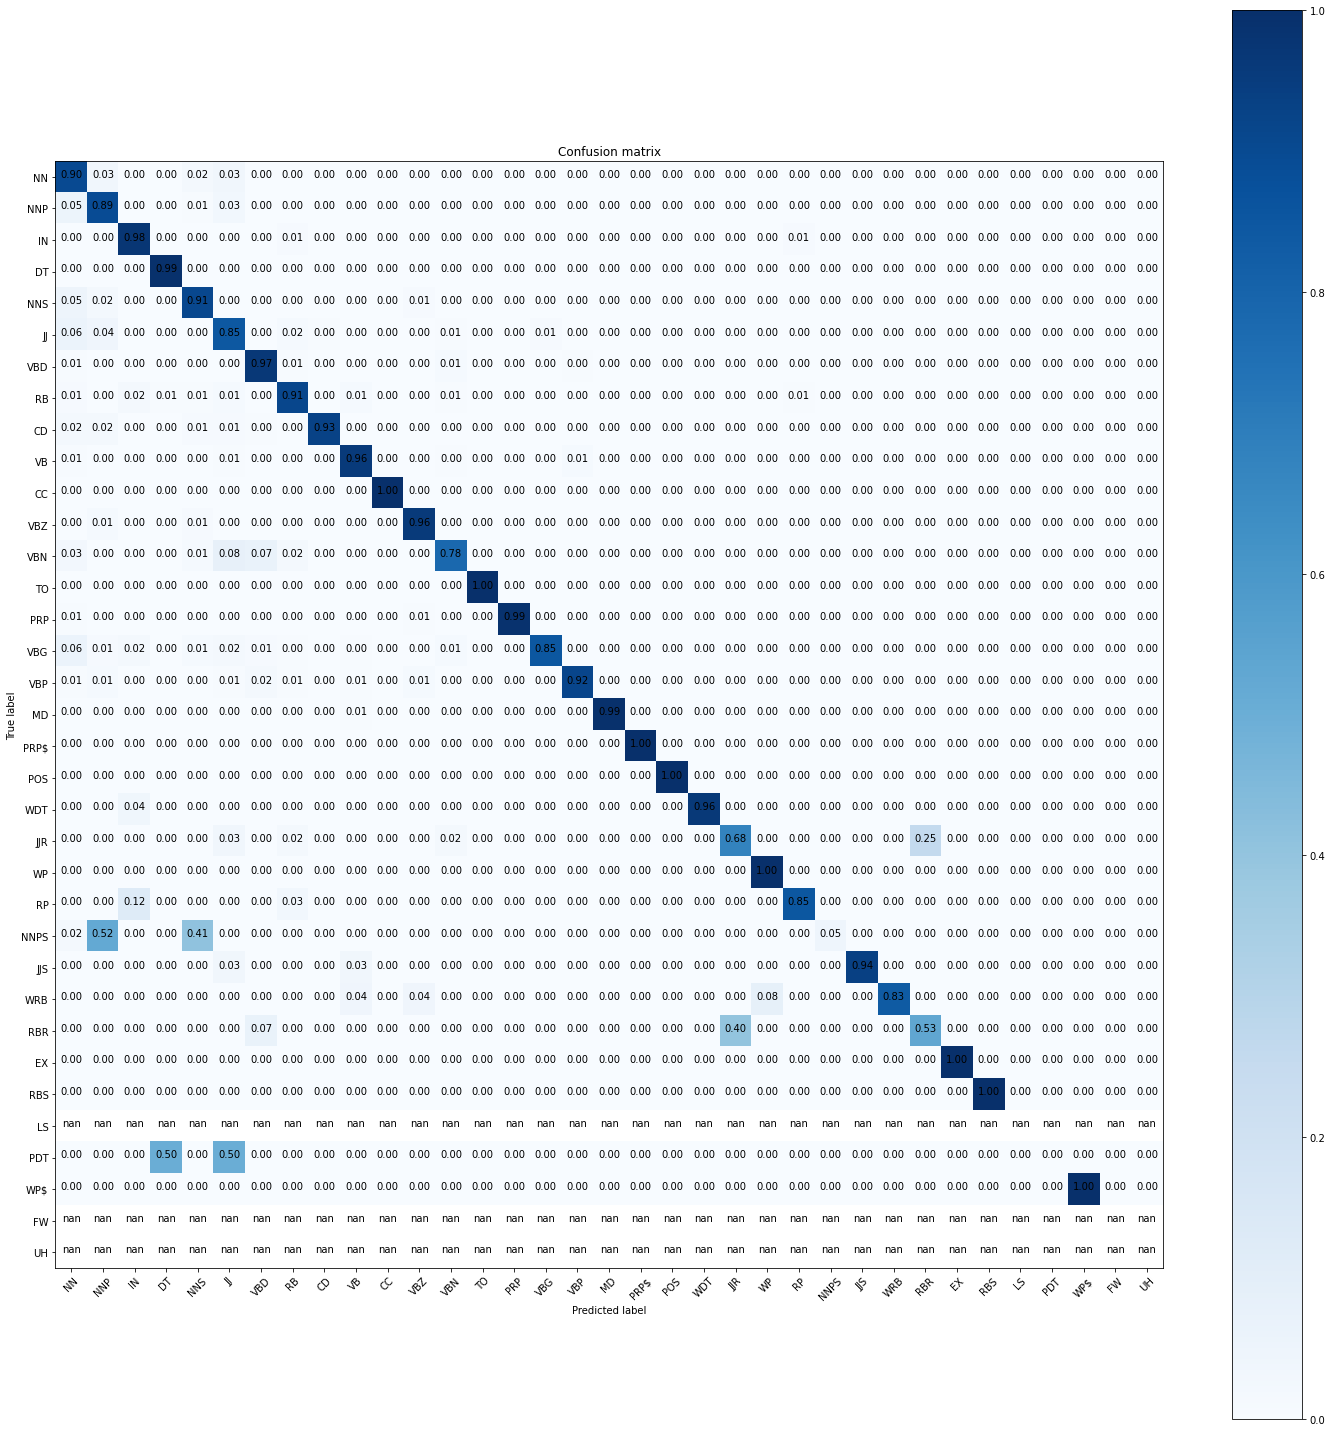

In [ ]:
from sklearn.metrics import confusion_matrix

tags_list = [TB_TAGS.vocab.itos[i] for i in tags_index]

confusion_matrix = confusion_matrix(y_true, y_pred, labels = tags_index)

plt.figure(figsize=(20,20))
plot_confusion_matrix(confusion_matrix, tags_list, normalize=True)


From the confusion matrix, it can be noticed that most of the tags are correctly predicted but the model seems to have troubles when predicting NNPS tags (proper plural nouns); the model, most of the times, misclassifies them with NNP (proper singular nouns) and NNS (plural nouns) tags and it is understandable. We worked with lowercase words since we have seen an improvement in the accuracy, but probably this has influenced some misclassification of proper nouns.

Another tags with low prediction performances, it is the PDT one (predeterminers), but this is probably due to its low frequency in the training set (just 9 occurrencies); however, in the test set, it is confused half of the times (2 out of 4) with DT tag (determiners).

Additionaly, it can be seen from the plot that some tags which are not present in the test set, produce nans values in the confusion matrix (LS, FW and UH).

##Classification Report

To have even a more in-depth view of the single tags performances, we compute a classifation report which includes, for each tag, precision, recall, and f1-score metrics.
The above considerations about the misclassification of proper nouns are here highlighted (NNP -> 2, NNPS -> 31).

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, labels=tags_index, zero_division=0)
print(report)

              precision    recall  f1-score   support

           1       0.90      0.90      0.90      2383
           2       0.02      0.89      0.04      1504
           3       0.98      0.98      0.98      1630
           4       0.99      0.99      0.99      1335
           5       0.90      0.91      0.90       941
           6       0.80      0.85      0.82       918
           9       0.93      0.97      0.95       634
          10       0.87      0.91      0.89       381
          11       0.98      0.93      0.95       858
          12       0.94      0.96      0.95       403
          13       0.99      1.00      1.00       366
          14       0.94      0.96      0.95       280
          15       0.91      0.78      0.84       366
          16       1.00      1.00      1.00       386
          17       1.00      0.99      0.99       192
          18       0.84      0.85      0.84       221
          19       0.90      0.92      0.91       134
          20       0.97    

# Credits

Alex Rossi: alex.rossi6@studio.unibo.it

Simone Gayed Said: simone.gayed@studio.unibo.it
